In [1]:
import pandas as pd
import numpy as np
import re,os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def read_vote_result(result_path,prefix,np_ratio,idx) :
    vote = np.load(result_path + '%s/%s__vote_np_ratio_%d.npy' % (prefix,prefix,np_ratio))
    df = pd.Series(vote,index=idx)
    idx = df.index.str.contains("ENSG")
    return df[idx]

def read_ensemble_result(result_path,prefix,np_ratio,gene_idx) : 

    vote = np.load(result_path + '%s/%s__vote_np_ratio_%d.npy' % (prefix,prefix,np_ratio))
    precision = np.load(result_path + '%s/%s__precision_np_ratio_%d.npy' % (prefix,prefix,np_ratio),allow_pickle=True)
    overall_p = np.load(result_path + '%s/%s__precision_overall_np_ratio_%d.npy' % (prefix,prefix,np_ratio),allow_pickle=True)
    recall = np.load(result_path + '%s/%s__recall_np_ratio_%d.npy' % (prefix,prefix,np_ratio),allow_pickle=True)
    overall_r = np.load(result_path + '%s/%s__recall_overall_np_ratio_%d.npy' % (prefix,prefix,np_ratio),allow_pickle=True)
    metric = pd.DataFrame({'Precision' : precision,'Precision_overall' : overall_p,
                       'Recall' : recall, 'Recall_overall' : overall_r})
    df = pd.Series(vote,index=gene_idx)
    idx = df.index.str.contains("ENSG")
    return df[idx],metric


In [3]:
from math import log10
def n_candidate_gene_lineplot(result_path,prefix,gene_idx,hallmark_genes,output_path) :
    n_candidate_gene_array = np.zeros(10)
    n_hallmark_gene_array = np.zeros(10)
    for idx,np_r in enumerate(np.arange(5,55,5)) :
        vote_result = read_vote_result(result_path,"%s_std_by_gene" % prefix,np_r,gene_idx)
        hallmark_result = vote_result[hallmark_genes]
        n_hallmark_gene_array[idx] = len(hallmark_result.index[hallmark_result > 0])
        n_candidate_gene_array[idx] = len(set(vote_result.index[vote_result > 0]) - set(hallmark_genes))

    fig, ax1 = plt.subplots(figsize = (8,5))
    ax2 = ax1.twinx()
    candidate_p = ax1.plot(np.arange(5,55,5),n_candidate_gene_array,marker='*',color = '#7DB9B6',label='Number of candidate genes')
    hallmark_p = ax2.plot(np.arange(5,55,5),n_hallmark_gene_array,marker='*',color = '#FFAACF',label='Number of hallmark genes')
    plt.xticks(np.arange(5,55,5))
    ax1.set_xlabel("N/P ratio")
    ax1.set_ylabel("Number of candidate genes")
    ax2.set_ylabel("Number of hallmark genes")
    lns = candidate_p + hallmark_p
    labs = [l.get_label() for l in lns]
    ax1.legend(lns,labs,loc=3)
    plt.title("Number of candidate genes in different N/P ratio (%s)" % prefix)
    if not os.path.exists(output_path) :
        os.mkdir(output_path)
    plt.savefig(output_path + 'number_of_candidate_genes_%s.png' % prefix , dpi = 300)

def hallmark_gene_vote_distribution(result_path,prefix,gene_idx,hallmark_genes,output_path) :
    candidate_vote = pd.DataFrame()
    hallmark_vote = pd.DataFrame()
    for np_r in np.arange(5,55,5) :
        vote_result = read_vote_result(result_path,"%s_std_by_gene" % prefix,np_r,gene_idx)
        candidate_genes = list(vote_result[vote_result > 0].index)
        df_c = pd.DataFrame({'Gene' : candidate_genes,'Vote' : [log10(x) if x > 0 else x for x in vote_result[candidate_genes].values],
                            'np_ratio' : [np_r] * len(candidate_genes),},index=candidate_genes)
        candidate_vote = pd.concat([candidate_vote,df_c])

        df_h = pd.DataFrame({'Gene' : hallmark_genes,'Vote' : [log10(x) if x > 0 else x for x in vote_result[hallmark_genes].values],
                            'np_ratio' : [np_r] * len(hallmark_genes),},index=hallmark_genes)
        hallmark_vote = pd.concat([hallmark_vote,df_h])
    if not os.path.exists(output_path) :
        os.mkdir(output_path)
    # plot hallmark vote distribution
    plt.figure(figsize=(15,5))
    sns.violinplot(data=hallmark_vote,x='np_ratio',y='Vote',palette='rainbow_r')
    sns.swarmplot(data=hallmark_vote,x='np_ratio',y='Vote',color= "black")
    plt.ylabel("Vote number (log10)")
    plt.title("Hallmark genes vote distribution (%s)" % prefix)
    plt.savefig(output_path + 'hallmark_gene_vote_distribution_%s.png' % prefix ,dpi = 300)
    plt.show()
    # plot candidate vote distribution
    plt.figure(figsize=(15,5))
    sns.violinplot(data=candidate_vote,x='np_ratio',y='Vote',palette='rainbow_r')
    sns.swarmplot(data=candidate_vote,x='np_ratio',y='Vote',color= "black")
    plt.ylabel("Vote number (log10)")
    plt.title("Candidate genes vote distribution (%s)" % prefix)
    plt.savefig(output_path + 'candidate_gene_vote_distribution_%s.png' % prefix ,dpi = 300)

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import roc_curve,auc

def model_performance(result_path,prefix,hallmark,gene_idx,metric,output_path) :

    no_syn_idx = gene_idx.str.contains("ENSG")
    metric_median = np.zeros(10)
    metric_std = np.zeros(10)
    overall_metric_median = np.zeros(10)
    overall_metric_std = np.zeros(10)
    auc_array = np.zeros(10) 
    auc_std_array = np.zeros(10)
    for np_idx,np_r in enumerate(np.arange(5,55,5)) :
        print("Predict hallmark gene by vote number of np ratio %d in %s condition" % (np_r,prefix))  
        vote_df,metric_df = read_ensemble_result(result_path,"%s_std_by_gene" % prefix,np_r,gene_idx)
        metric_median[np_idx] = np.median(metric_df[metric].values)
        metric_std[np_idx] = np.std(metric_df[metric].values)
        overall_metric_median[np_idx] = np.median(metric_df[metric+'_overall'].values)
        overall_metric_std[np_idx] = np.std(metric_df[metric+'_overall'].values)
        no_syn_gene = gene_idx[no_syn_idx]
        x = np.array(vote_df[no_syn_gene].values)
        y = np.array([1 if x in hallmark else 0 for x in no_syn_gene])
        
        #x_train,x_test,y_train,y_test = train_test_split(x.reshape(-1, 1),y.reshape(-1, 1),test_size = 0.2,stratify = y)
        svm = SVC(kernel='linear')
        cv_score = cross_val_score(svm,x.reshape(-1,1),y,cv=5,scoring='roc_auc')
        auc_array[np_idx] = np.median(cv_score)
        auc_std_array[np_idx] = cv_score.std()
        #fpr, tpr, threshold = roc_curve(y, x, pos_label=1)
        #auc_array[np_idx] = auc(fpr, tpr)

    plt.figure(figsize=(10,5))
    plt.errorbar(np.arange(5,55,5),metric_median,yerr = metric_std,marker = '*', label=metric.capitalize(),color = "darksalmon",ms = 10)
    plt.errorbar(np.arange(5,55,5),overall_metric_median,yerr = overall_metric_std, marker = '*',label='Overall ' +metric ,color = "mediumaquamarine",ms = 10)
    plt.errorbar(np.arange(5,55,5),auc_array,yerr=auc_std_array,marker = '*', label='AUC',color = "#FFAACF",ms = 10)
    plt.ylabel("Metrics")
    plt.ylim([0,1])
    plt.xlabel('N/P ratio')
    plt.legend()
    plt.title("Ensemble learning model performance (%s)" % (prefix))
    plt.savefig(output_path + 'ensemble_performance_predict_by_vote_%s_%s.png' % (metric,prefix),bbox_inches = 'tight',dpi=300)

Predict hallmark gene by vote number of np ratio 5 in hbv_only condition
Predict hallmark gene by vote number of np ratio 10 in hbv_only condition
Predict hallmark gene by vote number of np ratio 15 in hbv_only condition
Predict hallmark gene by vote number of np ratio 20 in hbv_only condition
Predict hallmark gene by vote number of np ratio 25 in hbv_only condition
Predict hallmark gene by vote number of np ratio 30 in hbv_only condition
Predict hallmark gene by vote number of np ratio 35 in hbv_only condition
Predict hallmark gene by vote number of np ratio 40 in hbv_only condition
Predict hallmark gene by vote number of np ratio 45 in hbv_only condition
Predict hallmark gene by vote number of np ratio 50 in hbv_only condition


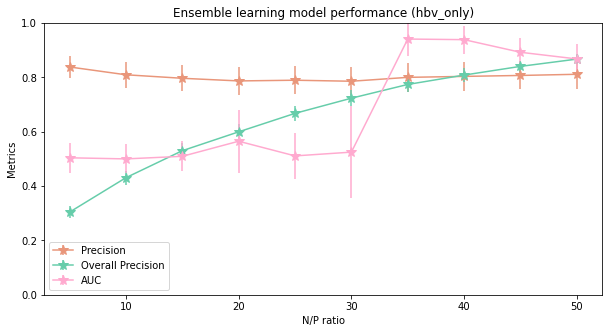

In [5]:
vote_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/with_synthetic/'
training_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/'
hallmark = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/data/hallmark_gene/hallmark_protein_coding_ens_id.txt',sep='\t')
hallmark_genes = hallmark['EnsID'].values
##
con = 'hbv_only'
exp_m = pd.read_csv(training_path + "%s_coding_gene_std_by_gene_with_synthetic.txt" % con,sep='\t',index_col=0)
model_performance(vote_path,con,hallmark_genes,exp_m.index,'Precision',"./")

### hallmark gene correlation

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split

In [ ]:
hallmark_list = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/hallmark_gene/hallmark_protein_coding_ens_id.txt",sep='\t')
hallmark_gene = hallmark_list['EnsID'].values
exp_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/'
condition = ['hbv_only','nonhbv_only','tumor_only','normal_only']
for con in condition :
    exp_m = pd.read_csv(exp_path + '%s_coding_gene_std_by_gene_with_synthetic.txt' % con,sep='\t',index_col=0)
    hallmark_exp = exp_m.loc[hallmark_gene,:]
    hallmark_corr = hallmark_exp.T.corr(method='pearson')
    hallmark_corr.to_csv("/home/bruce1996/data/LIHC_anomaly_detection/hallmark_characteristic/hallmark_consensus_clustering/tumor_hallmark_pearson_correlation_matrix.txt",sep='\t')
    sns.clustermap(hallmark_corr).fig.suptitle('Hallmark Pearson correlation coefficient matrix (%s)' % con,size=15) 
    plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/fig/hallmark_gene_characteristic/hallmark_gene_pearson_corr_matrix_in_%s.png" % con,dpi = 300)

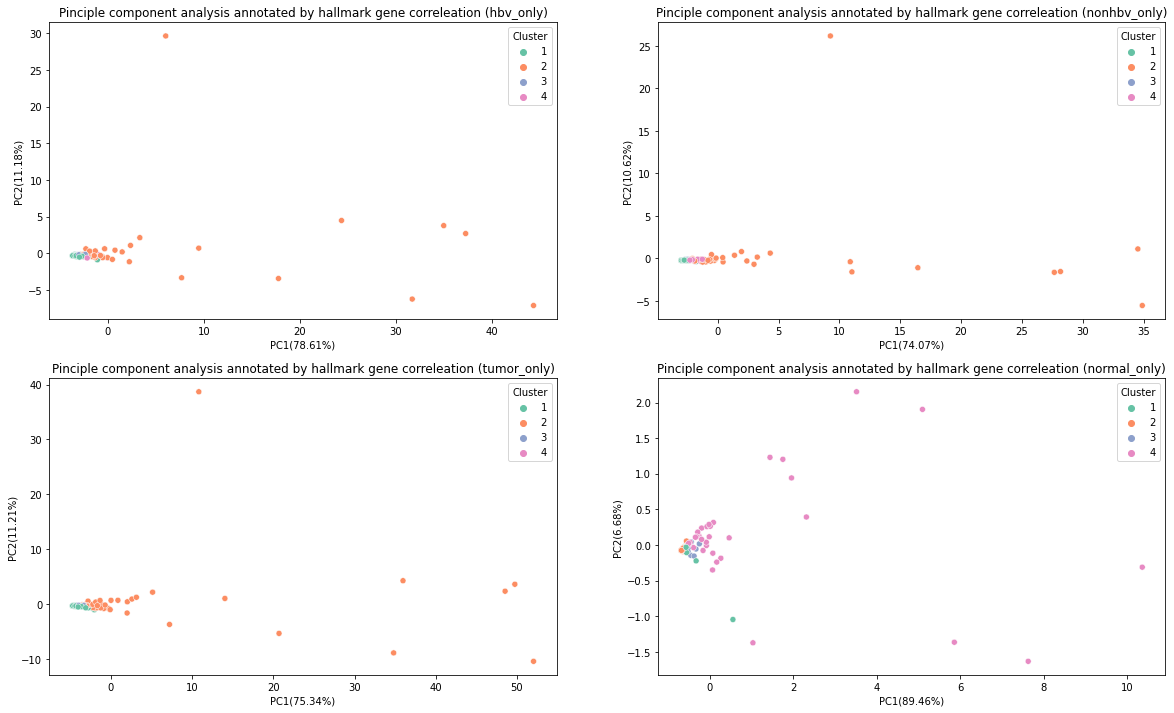

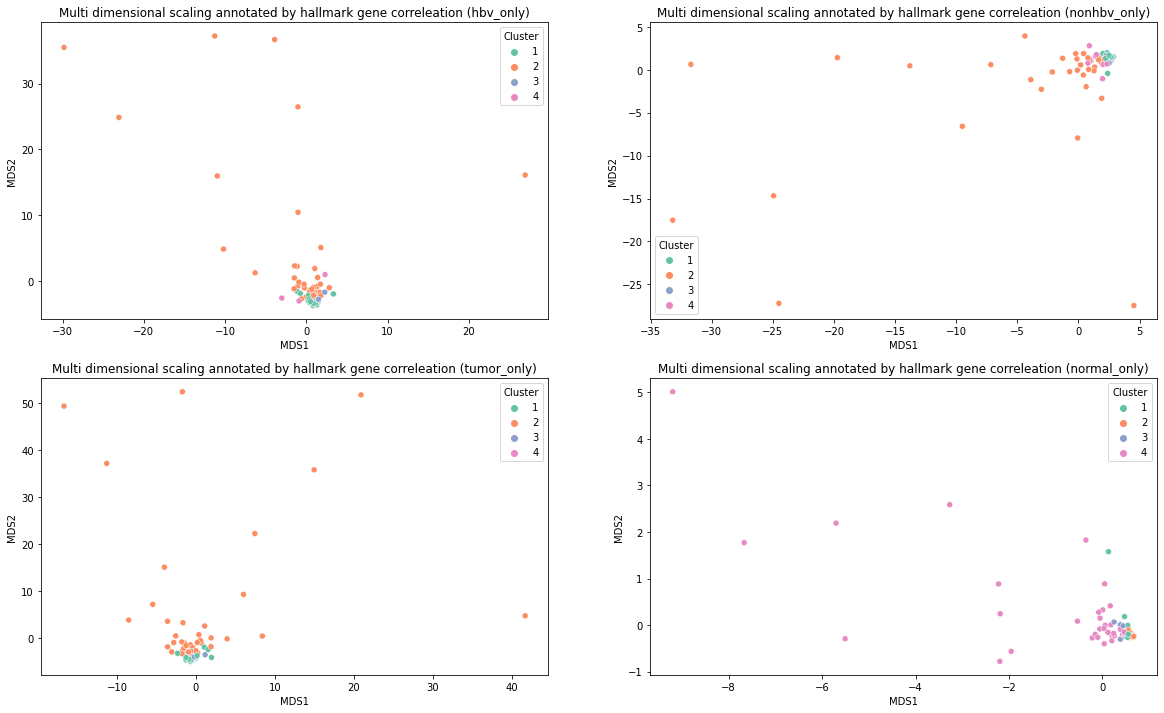

In [38]:
exp_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/'
condition = ['hbv_only','nonhbv_only','tumor_only','normal_only']

pca_fig, pca_axs = plt.subplots(2, 2,figsize=(20,12))
pca_axes = pca_axs.ravel()
mds_fig, mds_axs = plt.subplots(2,2,figsize=(20,12))
mds_axes = mds_axs.ravel()

for c_idx,con in enumerate(condition) :
    exp_m = pd.read_csv(exp_path + '%s_coding_gene_std_by_gene_with_synthetic.txt' % con,sep='\t',index_col=0)
    label = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/hallmark_characteristic/hallmark_consensus_clustering/%s_hallmark_consensus_result.txt" % con ,sep='\t',index_col=0)
    hallmark_exp = exp_m.loc[hallmark_gene,:]
    mds = MDS(n_components=2).fit_transform(hallmark_exp.to_numpy())
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hallmark_exp.to_numpy())
    label = label.loc[hallmark_gene,'cluster'].values
    plot_df = pd.DataFrame({'PC1' : pca_result[:,0],'PC2' : pca_result[:,1],'MDS1' : mds[:,0],'MDS2' : mds[:,1],'Cluster' : label})
    #plt.figure(figsize=(8,5))
    sns.scatterplot(data=plot_df,x='PC1',y='PC2',hue='Cluster',palette='Set2',ax=pca_axes[c_idx])
    pca_axes[c_idx].set_title("Pinciple component analysis annotated by hallmark gene correleation (%s)" % con)
    pca_axes[c_idx].set_xlabel("PC1({:.2f}%)".format(pca.explained_variance_ratio_[0]*100))
    pca_axes[c_idx].set_ylabel("PC2({:.2f}%)".format(pca.explained_variance_ratio_[1]*100))
    #plt.show()
    #plt.figure(figsize=(8,5))
    sns.scatterplot(data=plot_df,x='MDS1',y='MDS2',hue='Cluster',palette='Set2',ax=mds_axes[c_idx])
    mds_axes[c_idx].set_title("Multi dimensional scaling annotated by hallmark gene correleation (%s)" % con)
    #plt.show()
pca_fig.savefig("/home/bruce1996/data/LIHC_anomaly_detection/fig/hallmark_gene_characteristic/hallmark_consensus_pca.png",dpi=300,bbox_inches='tight')
mds_fig.savefig("/home/bruce1996/data/LIHC_anomaly_detection/fig/hallmark_gene_characteristic/hallmark_consensus_mds.png",dpi=300,bbox_inches='tight')


### explode outlier

In [5]:
from sklearn.ensemble import IsolationForest

In [6]:
exp_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/'
condition = ['hbv_only','nonhbv_only','tumor_only','normal_only']
vote_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/with_synthetic/'
training_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/'
hallmark = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/data/hallmark_gene/hallmark_protein_coding_ens_id.txt',sep='\t')
hallmark_genes = hallmark['EnsID'].values

In [10]:
outlier_dict = {}
outlier_score_dict = {}
outlier_list = set()
#pca_fig, pca_axs = plt.subplots(2, 2,figsize=(20,12))
#pca_axes = pca_axs.ravel()
anomaly_m = np.zeros([len(hallmark_genes),4])

for c_idx,con in enumerate(condition) :
    exp_m = pd.read_csv(exp_path + '%s_coding_gene_std_by_gene_with_synthetic.txt' % con,sep='\t',index_col=0)
    label = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/hallmark_characteristic/hallmark_consensus_clustering/%s_hallmark_consensus_result.txt" % con ,sep='\t',index_col=0)
    hallmark_exp = exp_m.loc[hallmark_genes,:]
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hallmark_exp.to_numpy())
    #ocsvm = OneClassSVM(kernel='linear').fit(pca_result)
    clf = IsolationForest(n_estimators=100)
    clf.fit(pca_result)
    anomaly_score = clf.decision_function(pca_result)
    anomaly_m[:,c_idx] = anomaly_score
    outlier_label = clf.predict(pca_result)
    label = label.loc[hallmark_genes,'cluster'].values
    #record outlier into dict
    outlier = hallmark_genes[outlier_label==-1]
    outlier_dict[con] = outlier
    outlier_score_dict[con] = anomaly_score
    for o in outlier :
        if o not in outlier_list :
            outlier_list.add(o)
    #plot result
    '''    
    plot_df = pd.DataFrame({'PC1' : pca_result[:,0],'PC2' : pca_result[:,1],'Cluster' : label,'Outlier' : outlier_label},index=hallmark_genes)
    sns.scatterplot(data=plot_df,x='PC1',y='PC2',hue='Cluster',style='Outlier',style_order=[1,-1],palette='Set2',ax=pca_axes[c_idx])
    pca_axes[c_idx].set_title("Outlier detection after PCA transfomation (%s)" % con)
    pca_axes[c_idx].set_xlabel("PC1({:.2f}%)".format(pca.explained_variance_ratio_[0]*100))
    pca_axes[c_idx].set_ylabel("PC2({:.2f}%)".format(pca.explained_variance_ratio_[1]*100))
    '''
#pca_fig.savefig("/home/bruce1996/data/LIHC_anomaly_detection/fig/hallmark_gene_characteristic/hallmark_consensus_pca_with_outlier.png",dpi=300,bbox_inches='tight')
    

In [25]:
import pickle

with open("/home/bruce1996/data/LIHC_anomaly_detection/data/coding_gene_info/hgnc2ensembl.pkl",'rb') as f :
    hgsc2ens = pickle.load(f)
f.close()

ens2hgsc = {}
for key,value in hgsc2ens.items() :
    ens2hgsc[value] = key

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

'''
outlier_m = pd.DataFrame(np.zeros([4,len(outlier_list)],dtype=int),index=condition,columns=[x for x in outlier_list])
for con in outlier_dict :
    outlier_m.loc[con,outlier_dict[con]] = 1
'''
hallmark_m  = pd.DataFrame(np.zeros([4,len(hallmark_gene)],dtype=int),index=condition,columns=hallmark_gene)
for con in outlier_score_dict :
    hallmark_m.loc[con,:] = outlier_score_dict[con]
outlier_m = hallmark_m.loc[:,outlier_list]
#outlier_m.columns = [ens2hgsc[x] for x in outlier_list]
s = outlier_m.sum()
outlier_m = outlier_m.loc[:,s.sort_values(ascending=False).index]
outlier_m.T.to_csv('/home/bruce1996/data/LIHC_anomaly_detection/hallmark_characteristic/outlier_matrix.txt',sep='\t')
#plot outlier
colors = ["#ADE4DB","#FFF9DE"] 
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
plt.figure(figsize=(5,12))
ax = sns.heatmap(outlier_m.T,cmap=cmap,linewidths=0.5, cbar_kws={"shrink": .5},center=0,annot=True)
ax.set_yticklabels([ens2hgsc[x] for x in outlier_list])
plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/fig/hallmark_gene_characteristic/outlier_in_different_condition_anomaly_score_heatmap.png",dpi=300,bbox_inches='tight')


### Vote number comparison between hallmark & outlier in different N/P ratio

In [52]:
condition = ['hbv_only','nonhbv_only','tumor_only','normal_only']
vote_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/without_synthetic/'
training_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/'
hallmark = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/data/hallmark_gene/hallmark_protein_coding_ens_id.txt',sep='\t')
hallmark_gene = hallmark['EnsID'].values
outlier_m = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/hallmark_characteristic/outlier_anomaly_score_matrix.txt',sep='\t',index_col=0)
outlier = list(outlier_m.index)

In [ ]:
np_ratio = np.arange(5,55,5)
for con in condition :
    exp_m = pd.read_csv(training_path+'lihc_coding_gene_std_by_gene_%s.txt' % con,sep='\t',index_col=0)
    plot_df = pd.DataFrame()
    con_outlier = list(outlier_m.index[outlier_m[con] <0])
    for npr in np_ratio :
        vote = np.load(vote_path+"%s_std_by_gene/%s_std_by_gene_vote_np_ratio_%d.npy" % (con,con,npr))
        vote_result = pd.DataFrame({'Vote' : vote},index=exp_m.index)
        hallmark_vote = pd.DataFrame({'Vote' :vote_result['Vote'][hallmark_gene],'NP_ratio' : [npr] * len(hallmark_gene)
                                      ,'Label' : ['Hallmark' if x not in con_outlier else 'Outlier' for x in hallmark_gene]},index=hallmark_gene)
        plot_df = pd.concat([plot_df,hallmark_vote])
    plt.figure(figsize=(10,4))
    sns.violinplot(data=plot_df,x='NP_ratio',y='Vote',hue='Label',palette='Set2')
    sns.swarmplot(data=plot_df,x='NP_ratio',y='Vote',hue='Label',palette='Set2',dodge=True)
    plt.title("Vote distribution between hallmark gene & outlier (%s,%d outliers)" % (con,len(con_outlier)))
    plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/fig/hallmark_gene_characteristic/vote_distribution/hallmark_vs_outlier_vote_distribution_%s_without_synthetic.png" % con,dpi=300,bbox_inches='tight')
    plt.show()